## Bring In The Data and Preview It

In [1]:
import os
import random
import numpy as np
import torch

def set_seed(seed= 24):
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    os.environ['PYTHONHASHSEED']= str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.use_deterministic_algorithms(True)

set_seed(24)

In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

username = 'Andrew_Reusche92'
api_key = '63cd28af853827307d2b6546dd833488'

api_token = {"username":username,"key":api_key}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d ronakgohil/license-plate-dataset

Dataset URL: https://www.kaggle.com/datasets/ronakgohil/license-plate-dataset
License(s): CC0-1.0


In [4]:
!unzip -q license-plate-dataset.zip -d data

In [5]:
# pip -q install scikeras

In [6]:
# pip -q install keras-tuner

Import relevant libraries.

In [7]:
#general purpose libraries
import os
import shutil
import math
import itertools
from glob import glob

#data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2

#pytorch core libraries
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#pytorch utilities
from torch.utils.data import Dataset, DataLoader

#TorchVision libraries
import torchvision
from torchvision import transforms
from torchvision.ops import generalized_box_iou

#Scikit-learn utilities
from sklearn.model_selection import train_test_split

In [8]:
#data paths
image_dir = 'data/archive/images/train'
label_dir = 'data/archive/labels/train'

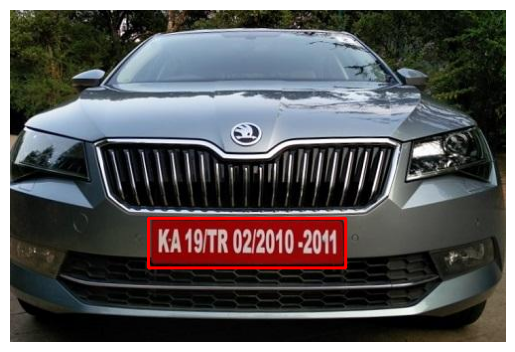

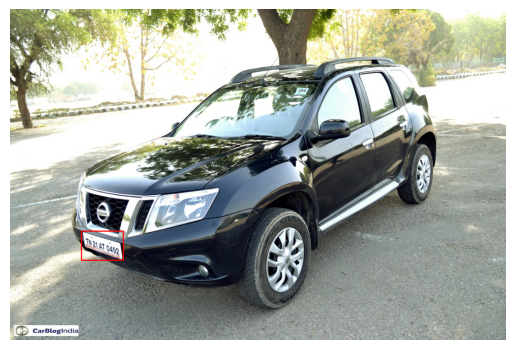

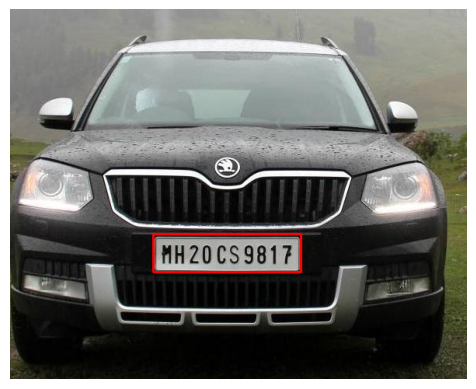

In [9]:
#deal with label paths that end in '.txt.txt'
def clean_label_path(label_path):
    if label_path.endswith('.txt.txt'):
        return label_path.replace('.txt.txt', '.txt')
    return label_path

#show images with boxes
def show_images_with_boxes(image_path, label_path, return_img= False):
  label_path= clean_label_path(label_path)
  img= cv2.imread(image_path)
  img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  h, w, _= img.shape

  with open(label_path, 'r') as f:
    boxes= f.readlines()

  for box in boxes:
    class_id, x_center, y_center, box_w, box_h= map(float, box.strip().split())
    x1= int((x_center - box_w / 2) *w)
    y1= int((y_center - box_h / 2) *h)
    x2= int((x_center + box_w / 2) *w)
    y2= int((y_center + box_h / 2) *h)
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

  if return_img:
    return img
  else:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

#show some examples
sample_imgs= sorted(os.listdir(image_dir))[:3]

for img_file in sample_imgs:
  label_file= os.path.splitext(img_file)[0] + '.txt'
  label_path= os.path.join(label_dir, label_file)
  image_path= os.path.join(image_dir, img_file)

  show_images_with_boxes(image_path, label_path)

## Data Exploration

In [10]:
#count the images in each directory
train_imgs= glob('data/archive/images/train/*.jpg')
train_labels= glob('data/archive/labels/train/*.txt')
val_imgs= glob('data/archive/images/val/*.jpg')
val_labels= glob('data/archive/labels/val/*.txt')

print('Train images:', len(train_imgs))
print('Train labels:', len(train_labels))
print('Validation images:', len(val_imgs))
print('Validation labels:', len(val_labels))

Train images: 1526
Train labels: 1526
Validation images: 169
Validation labels: 169


In [11]:
#make sure every image has a matching label file
def check_missing_labels(img_paths, label_dir):
    missing= []
    for img_path in img_paths:
        base= os.path.splitext(os.path.basename(img_path))[0]
        label_path= os.path.join(label_dir, base + ".txt")
        if not os.path.exists(label_path):
            missing.append(img_path)
    return missing

missing_train= check_missing_labels(train_imgs, 'data/archive/labels/train')
missing_val= check_missing_labels(val_imgs, 'data/archive/labels/val')

print(f"Missing labels in training set: {len(missing_train)}")
print(f"Missing labels in validation set: {len(missing_val)}")

Missing labels in training set: 0
Missing labels in validation set: 0


In [12]:
#check out the class distribution to confirm they are all "license plate"
with open("data/archive/classes.txt", "r") as f:
    classes= f.read().splitlines()

print(f"Classes ({len(classes)}): {classes}")

Classes (1): ['license_plate']


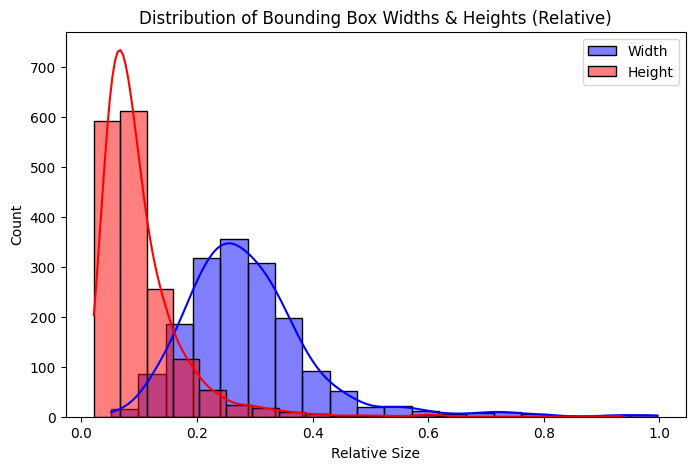

width       height
count  1695.000000  1695.000000
mean      0.288975     0.103054
std       0.117831     0.076331
min       0.051471     0.021452
25%       0.216295     0.057851
50%       0.272059     0.082589
75%       0.337444     0.123077
max       0.996667     0.934483

In [13]:
#check out bounding box size distribution
def get_bbox_dims(label_files):
    widths= []
    heights= []
    for lbl in label_files:
        with open(lbl, 'r') as f:
            for line in f.readlines():
                parts= line.strip().split()
                if len(parts) == 5:
                    _, _, _, w, h= map(float, parts)
                    widths.append(w)
                    heights.append(h)
    return pd.DataFrame({'width': widths, 'height': heights})

bbox_df= get_bbox_dims(train_labels + val_labels)

#plot the bounding box distribution
plt.figure(figsize=(8, 5))
sns.histplot(bbox_df['width'], bins=20, kde=True, color='blue', label='Width')
sns.histplot(bbox_df['height'], bins=20, kde=True, color='red', label='Height')
plt.title("Distribution of Bounding Box Widths & Heights (Relative)")
plt.xlabel("Relative Size")
plt.legend()
plt.show()

bbox_df.describe()

## Data Preprocessing

Letterbox resizing (padded resize)

In [14]:
#define input and output file paths
input_img_dir= "data/archive/images/train"
input_lbl_dir= "data/archive/labels/train"

output_img_dir= "data/processed/images"
output_lbl_dir= "data/processed/labels"

os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_lbl_dir, exist_ok=True)

In [15]:
#define target dimensions
target_w= 620
target_h= 512

#function to resize the images
def letterbox_resize(image, target_width, target_height):
    h, w= image.shape[:2]
    scale= min(target_width / w, target_height / h)
    new_w= int(w * scale)
    new_h= int(h * scale)

    resized= cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    pad_w= target_width - new_w
    pad_h= target_height - new_h
    top= pad_h // 2
    bottom= pad_h - top
    left= pad_w // 2
    right= pad_w - left

    padded= cv2.copyMakeBorder(resized,
                                top,
                                bottom,
                                left,
                                right,
                                cv2.BORDER_CONSTANT,
                                value=(114, 114, 114))

    return padded, scale, left, top, w, h

#function to resize the labels
def process_labels(label_path, scale, pad_left, pad_top, orig_w, orig_h):
    new_lines= []

    with open(label_path, 'r') as f:
        lines= f.readlines()

    for line in lines:
        class_id, x, y, w, h= map(float, line.strip().split())

        #undo YOLO normalization
        x *= orig_w
        y *= orig_h
        w *= orig_w
        h *= orig_h

        #scale
        x *= scale
        y *= scale
        w *= scale
        h *= scale

        #add padding offset
        x += pad_left
        y += pad_top

        #re-normalize
        x /= target_w
        y /= target_h
        w /= target_w
        h /= target_h

        new_lines.append(f"{int(class_id)} {x:.6f} {y:.6f} {w:.6f} {h:.6f}")

    return new_lines

#function to preprocess data subset
def preprocess_yolo_dataset(input_img_dir,
                            input_lbl_dir,
                            output_img_dir,
                            output_lbl_dir,
                            target_w=640,
                            target_h=512):

    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_lbl_dir, exist_ok=True)

    image_files= [f for f in os.listdir(input_img_dir)
                 if f.lower().endswith('.jpg')]

    for img_file in tqdm(image_files, desc=f"Preprocessing {os.path.basename(input_img_dir)}"):
        img_path= os.path.join(input_img_dir, img_file)
        label_filename= os.path.splitext(img_file)[0] + '.txt'
        label_path= os.path.join(input_lbl_dir, label_filename)

        image= cv2.imread(img_path)

        pad_img, scale, pad_left, pad_top, orig_w, orig_h= letterbox_resize(image,
                                                                            target_w,
                                                                            target_h)

        #save the padded image
        out_img_path= os.path.join(output_img_dir, img_file)
        cv2.imwrite(out_img_path, pad_img)

        #process and save image
        if os.path.exists(label_path):
            new_label_lines = process_labels(label_path,
                                             scale,
                                             pad_left,
                                             pad_top,
                                             orig_w,
                                             orig_h)

            out_lbl_path= os.path.join(output_lbl_dir,
                                        label_filename)

            with open(out_lbl_path, 'w') as f:
                f.write('\n'.join(new_label_lines))

In [16]:
#preprocess the train subset
preprocess_yolo_dataset(input_img_dir= 'data/archive/images/train',
    input_lbl_dir= 'data/archive/labels/train',
    output_img_dir= 'data/processed/images',
    output_lbl_dir= 'data/processed/labels')

#preprocess the validation subset
preprocess_yolo_dataset(input_img_dir= 'data/archive/images/val',
    input_lbl_dir= 'data/archive/labels/val',
    output_img_dir= 'data/processed_val/images',
    output_lbl_dir= 'data/processed_val/labels')

Preprocessing val: 100%|██████████| 169/169 [00:01<00:00, 127.46it/s]


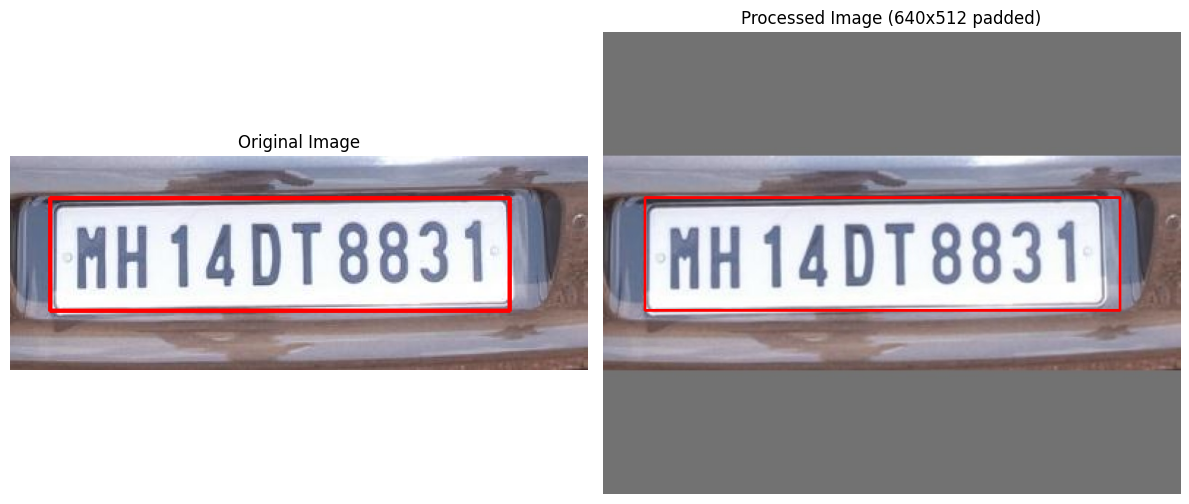

In [17]:
#create function to show image and bounding box before and after transformation
def show_images_side_by_side(img1_path, lbl1_path, img2_path, lbl2_path):
    img1= show_images_with_boxes(img1_path, lbl1_path, return_img=True)
    img2= show_images_with_boxes(img2_path, lbl2_path, return_img=True)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title("Processed Image (640x512 padded)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

#show before and after example from subset of uncomplicated file names
image_files= [f for f in os.listdir(input_img_dir) if f.lower().endswith('.jpg')]
trans_example= sorted(image_files)[8]
#fix label name edge cases
label_filename= os.path.splitext(trans_example)[0] + '.txt'


show_images_side_by_side(os.path.join(input_img_dir, trans_example),
                         os.path.join(input_lbl_dir, label_filename),
                         os.path.join(output_img_dir, trans_example),
                         os.path.join(output_lbl_dir, label_filename))

## Model Building and Data Analysis

### Train-Validation-Test Data Split

In [18]:
#preprocessed data paths
processed_train_img_dir= 'data/processed/images'
processed_train_lbl_dir= 'data/processed/labels'
processed_val_img_dir= 'data/processed_val/images'
processed_val_lbl_dir= 'data/processed_val/labels'

#output split base directory
split_base= 'data/final_split'
os.makedirs(split_base, exist_ok= True)

#get all preprocessed image-label pairs
train_images= sorted([f for f in os.listdir(processed_train_img_dir)
              if f.endswith('.jpg')])
train_pairs= [(f, os.path.splitext(f)[0] + '.txt') for f in train_images]

#train test split
train_split, test_split = train_test_split(train_pairs,
                                           test_size=0.1,
                                           random_state=24)
#copy image-label pairs to split directories
def copy_split(pairs, dest_split, src_img_dir, src_lbl_dir):
    img_out= os.path.join(split_base, dest_split, 'images')
    lbl_out= os.path.join(split_base, dest_split, 'labels')
    os.makedirs(img_out, exist_ok=True)
    os.makedirs(lbl_out, exist_ok=True)

    for img_file, lbl_file in tqdm(pairs, desc=f"Copying {dest_split}"):
        shutil.copy(os.path.join(src_img_dir, img_file),
                    os.path.join(img_out, img_file))
        shutil.copy(os.path.join(src_lbl_dir, lbl_file),
                    os.path.join(lbl_out, lbl_file))

#copy final splits
copy_split(train_split, 'train', processed_train_img_dir, processed_train_lbl_dir)
copy_split(test_split, 'test', processed_train_img_dir, processed_train_lbl_dir)

#copy preprocessed validation set as-is
val_pairs= [(f, os.path.splitext(f)[0] + '.txt')
            for f in os.listdir(processed_val_img_dir) if f.endswith('.jpg')]

copy_split(val_pairs, 'val', processed_val_img_dir, processed_val_lbl_dir)

#print the sizes from each split
print("\nTrain size:", len(os.listdir('data/final_split/train/images')))
print("Val size:  ", len(os.listdir('data/final_split/val/images')))
print("Test size: ", len(os.listdir('data/final_split/test/images')))

Copying val: 100%|██████████| 169/169 [00:00<00:00, 4728.96it/s]


Train size: 1373
Val size:   169
Test size:  153


## Utilize Pytorch for Bounding Boxes

In [19]:
class LicensePlateDataset(Dataset):
  def __init__(self, image_dir, label_dir, transform= None):
    self.image_dir= image_dir
    self.label_dir= label_dir
    self.image_files= sorted([f for f in os.listdir(image_dir)
                              if f.endswith('.jpg')])
    self.transform= transform

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    img_file= self.image_files[idx]
    label_file= os.path.splitext(img_file)[0] + '.txt'

    image_path= os.path.join(self.image_dir, img_file)
    label_path= os.path.join(self.label_dir, label_file)

    image= Image.open(image_path).convert('RGB')

    with open(label_path, 'r') as f:
      line= f.readline().strip()
      parts= line.split()
      bbox= torch.tensor(list(map(float, parts[1:])), dtype= torch.float32)

    if self.transform:
      image= self.transform(image)

    return image, bbox

In [20]:
transform= transforms.Compose([transforms.ToTensor(), ])

#path
base_path= 'data/final_split'

train_dataset= LicensePlateDataset(os.path.join(base_path, 'train/images'),
                                    os.path.join(base_path, 'train/labels'),
                                    transform=transform)

val_dataset= LicensePlateDataset(os.path.join(base_path, 'val/images'),
                                  os.path.join(base_path, 'val/labels'),
                                  transform=transform)

test_dataset= LicensePlateDataset(os.path.join(base_path, 'test/images'),
                                   os.path.join(base_path, 'test/labels'),
                                   transform=transform)

#data loaders
train_loader= DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader= DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader= DataLoader(test_dataset, batch_size=32, shuffle=False)

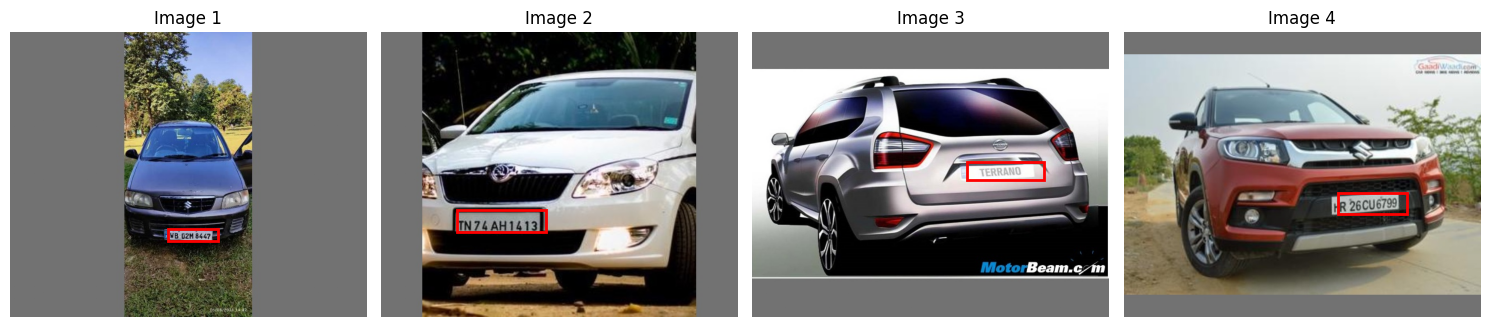

In [21]:
#preview transformed sample with bounding boxes
def show_batch_with_boxes(dataloader, batch_size= 4):
    images, bboxes= next(iter(dataloader))
    images= images[:batch_size]
    bboxes= bboxes[:batch_size]

    fig, axs= plt.subplots(1, batch_size, figsize= (15, 5))

    for i in range(batch_size):
        img= images[i].permute(1, 2, 0).numpy()
        h, w, _= img.shape

        x_center, y_center, box_w, box_h= bboxes[i].tolist()
        x1= int((x_center - box_w / 2) * w)
        y1= int((y_center - box_h / 2) * h)
        x2= int((x_center + box_w / 2) * w)
        y2= int((y_center + box_h / 2) * h)

        axs[i].imshow(img)
        axs[i].add_patch(plt.Rectangle((x1, y1),
                                       x2 - x1,
                                       y2 - y1,
                                       edgecolor='red',
                                       facecolor='none',
                                       linewidth=2))
        axs[i].axis('off')
        axs[i].set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()

show_batch_with_boxes(train_loader, batch_size= 4)

## Model Building and Data Analysis

In [22]:
#define dataset class
class LicensePlateDataset(torch.utils.data.Dataset):
  def __init__(self, image_dir, label_dir, transform= None):
    self.image_dir= image_dir
    self.label_dir= label_dir
    self.image_files= sorted([f for f in os.listdir(image_dir)
                              if f.endswith('.jpg')])
    self.transform= transform

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    img_file= self.image_files[idx]
    label_file= os.path.splitext(img_file)[0] + '.txt'
    image_path= os.path.join(self.image_dir, img_file)
    label_path= os.path.join(self.label_dir, label_file)

    image= Image.open(image_path).convert('RGB')

    with open(label_path, 'r') as f:
      line= f.readline().strip()
      parts= line.split()
      bbox= torch.tensor(list(map(float, parts[1:])), dtype= torch.float32)

    if self.transform:
      image= self.transform(image)

    return image, bbox

In [23]:
#create datasets and dataloaders
transform= transforms.Compose([transforms.ToTensor(), ])

#path
base_path= 'data/final_split'

train_dataset= LicensePlateDataset(os.path.join(base_path, 'train/images'),
                                    os.path.join(base_path, 'train/labels'),
                                    transform= transform)

val_dataset= LicensePlateDataset(os.path.join(base_path, 'val/images'),
                                  os.path.join(base_path, 'val/labels'),
                                  transform= transform)

test_dataset= LicensePlateDataset(os.path.join(base_path, 'test/images'),
                                   os.path.join(base_path, 'test/labels'),
                                   transform= transform)

#data loaders
train_loader= DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader= DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader= DataLoader(test_dataset, batch_size=16, shuffle=False)

In [24]:
#function to model trainer
def train_model(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                device,
                epochs=10,
                model_name= 'baseline_model.pth',
                verbose= True):

    best_val_loss= float('inf')
    history= {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
      print(f"\nEpoch {epoch+1}/{epochs}")
      model.train()
      train_losses= []

      for images, targets in train_loader:
            images, targets= images.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs= model(images)
            loss= criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

      avg_train_loss= np.mean(train_losses)

      #validatiopn
      model.eval()
      val_losses= []


      with torch.no_grad():
            for images, targets in val_loader:
                images, targets= images.to(device), targets.to(device)
                outputs= model(images)
                loss= criterion(outputs, targets)
                val_losses.append(loss.item())

      avg_val_loss= np.mean(val_losses)

      if verbose:
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

      history['train_loss'].append(avg_train_loss)
      history['val_loss'].append(avg_val_loss)

      #save best model
      if avg_val_loss < best_val_loss:
        best_val_loss= avg_val_loss
        torch.save(model.state_dict(), model_name)
        if verbose:
          print(f"Saved new best model: {model_name}")

    return history

In [25]:
#function to plot loss curves
def plot_loss_curves(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid()
    plt.show()

In [26]:
#function to visualize validation predictions
def show_predictions(model, dataloader, device, num_images= 4):
  model.eval()
  images, targets= next(iter(dataloader))
  images, targets= images.to(device), targets.to(device)

  preds= model(images)

  images= images.cpu()
  preds= preds.cpu()
  targets= targets.cpu()

  fig, axes= plt.subplots(1, num_images, figsize= (15, 5))
  for i in range(num_images):
    img= images[i].permute(1, 2, 0).numpy()
    h, w, _= img.shape

    pred_box= preds[i]
    gt_box= targets[i]

    #predicted box
    px1= int((pred_box[0] - pred_box[2] / 2) * w)
    py1= int((pred_box[1] - pred_box[3] / 2) * h)
    px2= int((pred_box[0] + pred_box[2] / 2) * w)
    py2= int((pred_box[1] + pred_box[3] / 2) * h)

    #true box
    gx1= int((gt_box[0] - gt_box[2] / 2) * w)
    gy1= int((gt_box[1] - gt_box[3] / 2) * h)
    gx2= int((gt_box[0] + gt_box[2] / 2) * w)
    gy2= int((gt_box[1] + gt_box[3] / 2) * h)

    axes[i].imshow(img)
    axes[i].add_patch(plt.Rectangle((px1, py1),
                                   px2- px1,
                                   py2- py1,
                                   edgecolor= 'red',
                                   facecolor= 'none',
                                   linewidth= 2))
    axes[i].add_patch(plt.Rectangle((gx1, gy1),
                                   gx2- gx1,
                                   gy2- gy1,
                                   edgecolor= 'green',
                                   facecolor= 'none',
                                   linewidth= 2))
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()

In [27]:
#function to compute IoU for validation set
def compute_iou(box1, box2):
  x1_min= box1[0] - box1[2]/ 2
  x1_max= box1[0] + box1[2]/ 2
  y1_min= box1[1] - box1[3]/ 2
  y1_max= box1[1] + box1[3]/ 2

  x2_min= box2[0] - box2[2]/ 2
  x2_max= box2[0] + box2[2]/ 2
  y2_min= box2[1] - box2[3]/ 2
  y2_max= box2[1] + box2[3]/ 2

  inter_xmin= max(x1_min, x2_min)
  inter_ymin= max(y1_min, y2_min)
  inter_xmax= max(x1_max, x2_max)
  inter_ymax= max(y1_max, y2_max)

  inter_w= max(inter_xmax - inter_xmin, 0)
  inter_h= max(inter_ymax - inter_ymin, 0)
  inter_area= inter_w * inter_h

  area1= (x1_max - x1_min) * (y1_max - y1_min)
  area2= (x2_max - x2_min) * (y2_max - y2_min)

  union_area= area1 + area2 - inter_area

  iou= inter_area / union_area if union_area > 0 else 0
  iou= max(0, min(iou, 1))
  return iou

In [28]:
#function to evaluate iou of model
def evaluate_iou_with_plot(model, loader, device):
  model.eval()
  ious= []

  with torch.no_grad():
    for images, targets in loader:
      images, targets= images.to(device), targets.to(device)
      preds= model(images)

      preds= preds.clone()
      preds[:, 2:]= preds[:, 2:].clamp(min= 1e-6, max= 1.0)
      preds[:, :2]= preds[:, :2].clamp(min= 0.0, max= 1.0)

      preds= preds.cpu()
      targets= targets.cpu()

      for pred, target in zip(preds, targets):
        ious.append(compute_iou(pred, target))

  mean_iou= np.mean(ious)

  print(f"Mean IoU: {mean_iou:.4f}")

  #plot iou histogram
  plt.figure(figsize=(8, 5))
  plt.hist(ious, bins=20, color='skyblue', edgecolor='black')
  plt.title("Distribution of IoU scores on Validation Set")
  plt.xlabel("IoU Score")
  plt.ylabel("Frequency")
  plt.grid(True)
  plt.show()

  return ious

### Baseline Model

In [29]:
#define baseline cnn model for bounding box regression
class SimpleBBoxCNN(nn.Module):
 def __init__(self):
   super(SimpleBBoxCNN, self).__init__()
   self.conv1= nn.Conv2d(3, 16, kernel_size= 3, stride= 2, padding= 1)
   self.conv2= nn.Conv2d(16, 32, kernel_size= 3, stride= 2, padding= 1)
   self.conv3= nn.Conv2d(32, 64, kernel_size= 3, stride= 2, padding= 1)
   self.conv4= nn.Conv2d(64, 128, kernel_size= 3, stride= 2, padding= 1)

   #compress dimension
   self.pool= nn.AdaptiveAvgPool2d((1, 1))
   #output x_center, y_center, width, height
   self.fc= nn.Linear(128, 4)

 def forward(self, x):
   x= F.relu(self.conv1(x))
   x= F.relu(self.conv2(x))
   x= F.relu(self.conv3(x))
   x= F.relu(self.conv4(x))
   x= self.pool(x)
   x= x.view(x.size(0), -1)
   x= self.fc(x)
   x= torch.sigmoid(x)
   return x

In [30]:
#run the model and evaluate
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model= SimpleBBoxCNN().to(device)
criterion= nn.MSELoss()
optimizer= optim.Adam(model.parameters(), lr= 0.0001)

history= train_model(model,
                     train_loader,
                     val_loader,
                     criterion,
                     optimizer,
                     device,
                     epochs= 10,
                     model_name= 'baseline_model.pth')

plot_loss_curves(history)

#load best model (lowest Val loss)
model.load_state_dict(torch.load('baseline_model.pth'))
model.to(device)

#visualize validation predictions
show_predictions(model, val_loader, device, num_images= 4)

#evaluate the validation set's IoU
evaluate_iou_with_plot(model, val_loader, device)


Epoch 1/10


KeyboardInterrupt: 

### Second Model

In [31]:
#create second model architecture
class SecondModel(nn.Module):
  def __init__(self):
    super(SecondModel, self).__init__()
    self.conv1= nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    self.bn1= nn.BatchNorm2d(32)
    self.conv2= nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn2= nn.BatchNorm2d(64)
    self.conv3= nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn3= nn.BatchNorm2d(128)
    self.conv4= nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.bn4= nn.BatchNorm2d(256)
    self.conv5= nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
    self.bn5= nn.BatchNorm2d(512)

    self.pool= nn.AdaptiveAvgPool2d((1, 1))
    self.dropout= nn.Dropout(0.3)
    self.fc= nn.Linear(512, 4)

  def forward(self, x):
    x= F.relu(self.bn1(self.conv1(x)))
    x= F.max_pool2d(x, 2)
    x= F.relu(self.bn2(self.conv2(x)))
    x= F.max_pool2d(x, 2)
    x= F.relu(self.bn3(self.conv3(x)))
    x= F.max_pool2d(x, 2)
    x= F.relu(self.bn4(self.conv4(x)))
    x= F.max_pool2d(x, 2)
    x= F.relu(self.bn5(self.conv5(x)))
    x= self.pool(x)

    x= x.view(x.size(0), -1)
    x= self.dropout(x)
    x= self.fc(x)
    x= torch.sigmoid(x)
    return x


Epoch 1/50
Train Loss: 0.0272 | Val Loss: 0.0207
Saved new best model: second_model_best.pth

Epoch 2/50
Train Loss: 0.0125 | Val Loss: 0.0198
Saved new best model: second_model_best.pth

Epoch 3/50
Train Loss: 0.0114 | Val Loss: 0.0169
Saved new best model: second_model_best.pth

Epoch 4/50
Train Loss: 0.0109 | Val Loss: 0.0188

Epoch 5/50
Train Loss: 0.0107 | Val Loss: 0.0169

Epoch 6/50
Train Loss: 0.0103 | Val Loss: 0.0176

Epoch 7/50
Train Loss: 0.0098 | Val Loss: 0.0154
Saved new best model: second_model_best.pth

Epoch 8/50
Train Loss: 0.0099 | Val Loss: 0.0179

Epoch 9/50
Train Loss: 0.0094 | Val Loss: 0.0160

Epoch 10/50
Train Loss: 0.0092 | Val Loss: 0.0196

Epoch 11/50
Train Loss: 0.0090 | Val Loss: 0.0175

Epoch 12/50
Train Loss: 0.0089 | Val Loss: 0.0167

Epoch 13/50
Train Loss: 0.0087 | Val Loss: 0.0183

Epoch 14/50
Train Loss: 0.0088 | Val Loss: 0.0184

Epoch 15/50
Train Loss: 0.0085 | Val Loss: 0.0165

Epoch 16/50
Train Loss: 0.0084 | Val Loss: 0.0177

Epoch 17/50
Trai

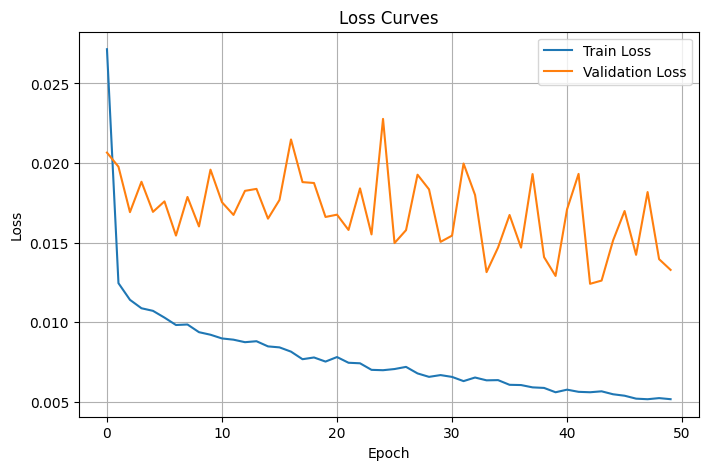

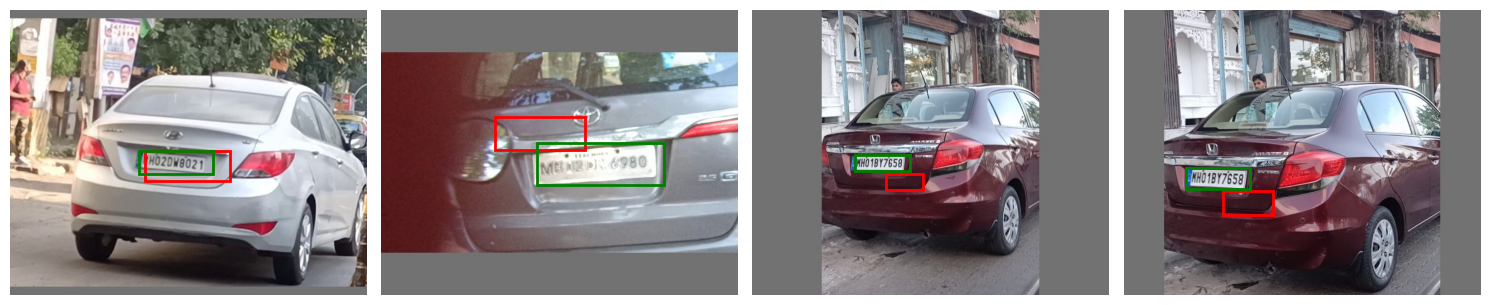

Mean IoU: 0.8735


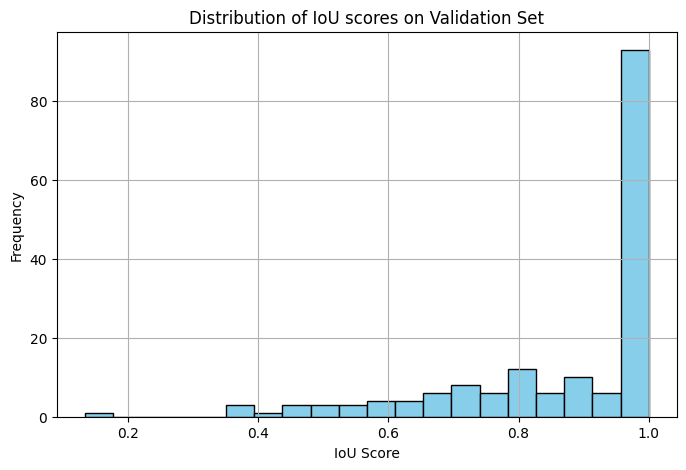

[1,
 1,
 tensor(0.6486),
 tensor(0.9458),
 tensor(0.8159),
 tensor(0.7249),
 tensor(0.7892),
 tensor(0.7819),
 tensor(0.7731),
 tensor(0.8117),
 tensor(0.8616),
 tensor(0.9161),
 tensor(0.8079),
 tensor(0.5386),
 tensor(0.5457),
 tensor(0.7260),
 tensor(0.7846),
 1,
 1,
 1,
 1,
 tensor(0.6736),
 tensor(0.6939),
 1,
 tensor(0.5081),
 tensor(0.3693),
 tensor(0.4559),
 1,
 1,
 1,
 1,
 tensor(0.6757),
 tensor(0.7878),
 tensor(0.8263),
 tensor(0.8327),
 tensor(0.9331),
 1,
 1,
 1,
 tensor(0.8735),
 1,
 tensor(0.9916),
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 tensor(0.5170),
 tensor(0.5803),
 tensor(0.5516),
 tensor(0.6997),
 tensor(0.9453),
 1,
 1,
 tensor(0.9084),
 tensor(0.7286),
 1,
 1,
 tensor(0.6609),
 tensor(0.6114),
 tensor(0.7439),
 tensor(0.7371),
 1,
 tensor(0.7843),
 1,
 1,
 1,
 1,
 tensor(0.8921),
 tensor(0.8889),
 tensor(0.6126),
 1,
 tensor(0.8739),
 tensor(0.7613),
 1,
 tensor(0.9853),
 1,
 tensor(0.4415),
 tensor(0.3746),
 tensor(0.3779),
 tensor(0.6509),
 tensor(0.6828),
 tenso

In [32]:
#instantiate model
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
second_model= SecondModel().to(device)

#define loss and optimizer
criterion= nn.MSELoss()
optimizer= torch.optim.AdamW(second_model.parameters(),
                             lr=0.0001,
                             weight_decay= 0.0001)

#train my model
history_second = train_model(second_model,
                      train_loader,
                      val_loader,
                      criterion,
                      optimizer,
                      device,
                      epochs= 50,
                      model_name= "second_model_best.pth")

plot_loss_curves(history_second)

#load best model (lowest Val loss)
second_model.load_state_dict(torch.load('second_model_best.pth'))
second_model.to(device)

#visualize validation predictions
show_predictions(second_model, val_loader, device, num_images= 4)

#evaluate the validation set's IoU
evaluate_iou_with_plot(second_model, val_loader, device)

### Third Model

In [33]:
class ThirdModel(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(ThirdModel, self).__init__()
        self.conv1= nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1= nn.BatchNorm2d(32)
        self.conv2= nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2= nn.BatchNorm2d(64)
        self.conv3= nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3= nn.BatchNorm2d(128)
        self.conv4= nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4= nn.BatchNorm2d(256)
        self.conv5= nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5= nn.BatchNorm2d(512)

        self.pool= nn.AdaptiveAvgPool2d((1, 1))
        self.dropout= nn.Dropout(dropout_rate)
        self.fc= nn.Linear(512, 4)

    def forward(self, x):
        x= F.relu(self.bn1(self.conv1(x)))
        x= F.max_pool2d(x, 2)
        x= F.relu(self.bn2(self.conv2(x)))
        x= F.max_pool2d(x, 2)
        x= F.relu(self.bn3(self.conv3(x)))
        x= F.max_pool2d(x, 2)
        x= F.relu(self.bn4(self.conv4(x)))
        x= F.max_pool2d(x, 2)
        x= F.relu(self.bn5(self.conv5(x)))
        x= self.pool(x)

        x= x.view(x.size(0), -1)
        x= self.dropout(x)
        x= self.fc(x)
        x= torch.sigmoid(x)
        return x


Epoch 1/50
Train Loss: 0.0318 | Val Loss: 0.0223
Saved new best model: third_model_tuned.pth

Epoch 2/50
Train Loss: 0.0115 | Val Loss: 0.0193
Saved new best model: third_model_tuned.pth

Epoch 3/50
Train Loss: 0.0105 | Val Loss: 0.0194

Epoch 4/50
Train Loss: 0.0098 | Val Loss: 0.0156
Saved new best model: third_model_tuned.pth

Epoch 5/50
Train Loss: 0.0094 | Val Loss: 0.0182

Epoch 6/50
Train Loss: 0.0093 | Val Loss: 0.0187

Epoch 7/50
Train Loss: 0.0087 | Val Loss: 0.0161

Epoch 8/50
Train Loss: 0.0086 | Val Loss: 0.0185

Epoch 9/50
Train Loss: 0.0083 | Val Loss: 0.0169

Epoch 10/50
Train Loss: 0.0081 | Val Loss: 0.0164

Epoch 11/50
Train Loss: 0.0078 | Val Loss: 0.0179

Epoch 12/50
Train Loss: 0.0076 | Val Loss: 0.0168

Epoch 13/50
Train Loss: 0.0076 | Val Loss: 0.0176

Epoch 14/50
Train Loss: 0.0075 | Val Loss: 0.0182

Epoch 15/50
Train Loss: 0.0071 | Val Loss: 0.0173

Epoch 16/50
Train Loss: 0.0071 | Val Loss: 0.0203

Epoch 17/50
Train Loss: 0.0070 | Val Loss: 0.0151
Saved new 

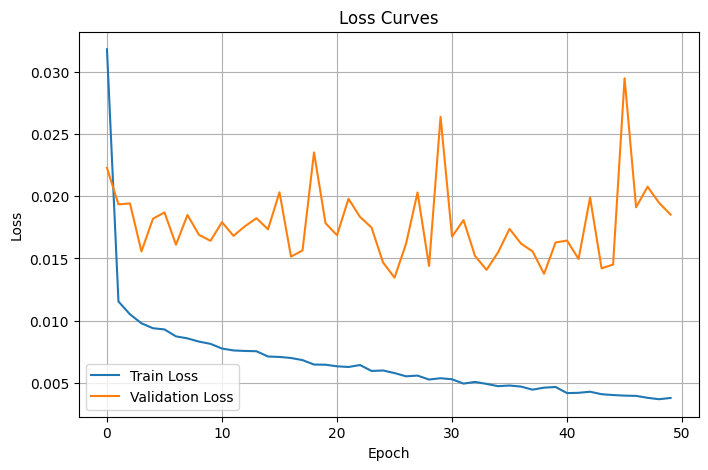

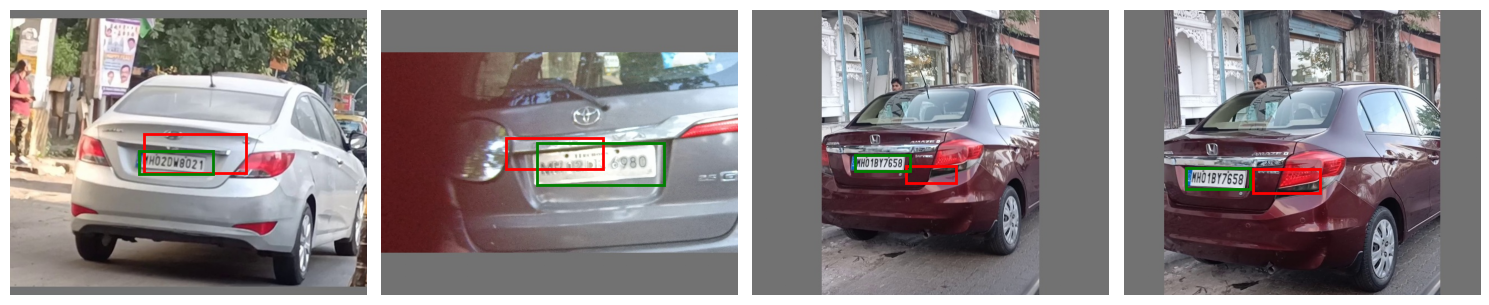

Mean IoU: 0.8921


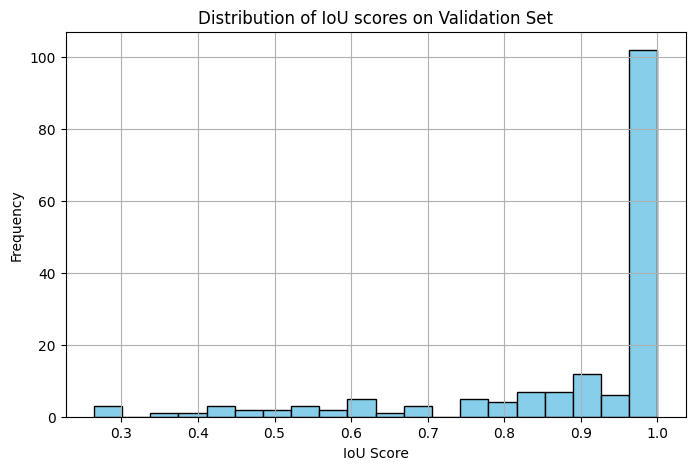

[tensor(0.7013),
 1,
 tensor(0.9166),
 1,
 tensor(0.8900),
 tensor(0.8234),
 tensor(0.9356),
 tensor(0.9185),
 tensor(0.8692),
 tensor(0.9374),
 tensor(0.9029),
 tensor(0.9496),
 tensor(0.8803),
 tensor(0.6112),
 tensor(0.5059),
 tensor(0.6043),
 tensor(0.8523),
 1,
 1,
 1,
 1,
 tensor(0.4681),
 tensor(0.6110),
 tensor(0.9173),
 tensor(0.4475),
 tensor(0.7650),
 tensor(0.2903),
 1,
 1,
 1,
 1,
 tensor(0.8149),
 tensor(0.8921),
 tensor(0.9392),
 tensor(0.8965),
 tensor(0.9653),
 1,
 1,
 1,
 tensor(0.9612),
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 tensor(0.5899),
 tensor(0.6196),
 tensor(0.5594),
 tensor(0.8913),
 1,
 1,
 1,
 tensor(0.8870),
 tensor(0.7757),
 1,
 1,
 tensor(0.8399),
 tensor(0.6781),
 tensor(0.8573),
 1,
 1,
 1,
 1,
 tensor(0.9011),
 1,
 1,
 1,
 tensor(0.8793),
 tensor(0.9234),
 1,
 1,
 tensor(0.8195),
 1,
 1,
 1,
 tensor(0.5400),
 tensor(0.2640),
 tensor(0.3905),
 tensor(0.3686),
 tensor(0.7861),
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 tensor(0.7806)

In [34]:
#lets rerun the third model but with these parameters
#instantiate
third_model_tuned= ThirdModel(dropout_rate= 0.0).to(device)

#optimizer
optimizer= torch.optim.AdamW(third_model_tuned.parameters(),
                             lr= 0.0001,
                             weight_decay= 0.0001)

#loss
criterion= nn.MSELoss()

#train
history_third_tuned= train_model(third_model_tuned,
                                 train_loader,
                                 val_loader,
                                 criterion,
                                 optimizer,
                                 device,
                                 epochs= 50,
                                 model_name= 'third_model_tuned.pth')

#plot loss curves
plot_loss_curves(history_third_tuned)

#load best saved model
third_model_tuned.load_state_dict(torch.load('third_model_tuned.pth'))
third_model_tuned.to(device)

#visualize predictions
show_predictions(third_model_tuned, val_loader, device, num_images= 4)

#tuned validation IoU
evaluate_iou_with_plot(third_model_tuned, val_loader, device)

### Fourth Model

In [35]:
#make fourth deeper model
class FourthModel(nn.Module):
  def __init__(self, dropout_rate= 0.0):
    super(FourthModel, self).__init__()
    self.conv1= nn.Conv2d(3, 32, kernel_size= 3, padding= 1)
    self.bn1= nn.BatchNorm2d(32)
    self.conv1b= nn.Conv2d(32, 32, kernel_size= 3, padding= 1)
    self.bn1b= nn.BatchNorm2d(32)

    self.conv2= nn.Conv2d(32, 64, kernel_size= 3, padding= 1)
    self.bn2= nn.BatchNorm2d(64)
    self.conv2b= nn.Conv2d(64, 64, kernel_size= 3, padding= 1)
    self.bn2b= nn.BatchNorm2d(64)

    self.conv3= nn.Conv2d(64, 128, kernel_size= 3, padding= 1)
    self.bn3= nn.BatchNorm2d(128)
    self.conv3b= nn.Conv2d(128, 128, kernel_size= 3, padding= 1)
    self.bn3b= nn.BatchNorm2d(128)

    self.conv4= nn.Conv2d(128, 256, kernel_size= 3, padding= 1)
    self.bn4= nn.BatchNorm2d(256)
    self.conv4b= nn.Conv2d(256, 256, kernel_size= 3, padding= 1)
    self.bn4b= nn.BatchNorm2d(256)

    self.conv5= nn.Conv2d(256, 512, kernel_size= 3, padding= 1)
    self.bn5= nn.BatchNorm2d(512)
    self.conv5b= nn.Conv2d(512, 512, kernel_size= 3, padding= 1)
    self.bn5b= nn.BatchNorm2d(512)

    self.pool= nn.AdaptiveAvgPool2d((1, 1))
    self.dropout= nn.Dropout(dropout_rate)
    self.fc= nn.Linear(512, 4)

  def forward(self, x):
    x= F.leaky_relu(self.bn1(self.conv1(x)), negative_slope= 0.1)
    x= F.leaky_relu(self.bn1b(self.conv1b(x)), negative_slope= 0.1)
    x= F.max_pool2d(x, 2)

    x= F.leaky_relu(self.bn2(self.conv2(x)), negative_slope= 0.1)
    x= F.leaky_relu(self.bn2b(self.conv2b(x)), negative_slope= 0.1)
    x= F.max_pool2d(x, 2)

    x= F.leaky_relu(self.bn3(self.conv3(x)), negative_slope= 0.1)
    x= F.leaky_relu(self.bn3b(self.conv3b(x)), negative_slope= 0.1)
    x= F.max_pool2d(x, 2)

    x= F.leaky_relu(self.bn4(self.conv4(x)), negative_slope= 0.1)
    x= F.leaky_relu(self.bn4b(self.conv4b(x)), negative_slope= 0.1)
    x= F.max_pool2d(x, 2)

    x= F.leaky_relu(self.bn5(self.conv5(x)), negative_slope= 0.1)
    x= F.leaky_relu(self.bn5b(self.conv5b(x)), negative_slope= 0.1)
    x= self.pool(x)

    x= x.view(x.size(0), -1)
    x= self.dropout(x)
    x= self.fc(x)
    x= torch.sigmoid(x)
    return x


Epoch 1/50
Train Loss: 0.0211 | Val Loss: 0.0220
Saved new best model: fourth_model.pth

Epoch 2/50
Train Loss: 0.0109 | Val Loss: 0.0216
Saved new best model: fourth_model.pth

Epoch 3/50
Train Loss: 0.0100 | Val Loss: 0.0187
Saved new best model: fourth_model.pth

Epoch 4/50
Train Loss: 0.0098 | Val Loss: 0.0164
Saved new best model: fourth_model.pth

Epoch 5/50
Train Loss: 0.0092 | Val Loss: 0.0204

Epoch 6/50
Train Loss: 0.0090 | Val Loss: 0.0201

Epoch 7/50
Train Loss: 0.0085 | Val Loss: 0.0158
Saved new best model: fourth_model.pth

Epoch 8/50
Train Loss: 0.0080 | Val Loss: 0.0165

Epoch 9/50
Train Loss: 0.0075 | Val Loss: 0.0248

Epoch 10/50
Train Loss: 0.0076 | Val Loss: 0.0169

Epoch 11/50
Train Loss: 0.0072 | Val Loss: 0.0168

Epoch 12/50
Train Loss: 0.0068 | Val Loss: 0.0160

Epoch 13/50
Train Loss: 0.0064 | Val Loss: 0.0142
Saved new best model: fourth_model.pth

Epoch 14/50
Train Loss: 0.0064 | Val Loss: 0.0237

Epoch 15/50
Train Loss: 0.0060 | Val Loss: 0.0147

Epoch 16/

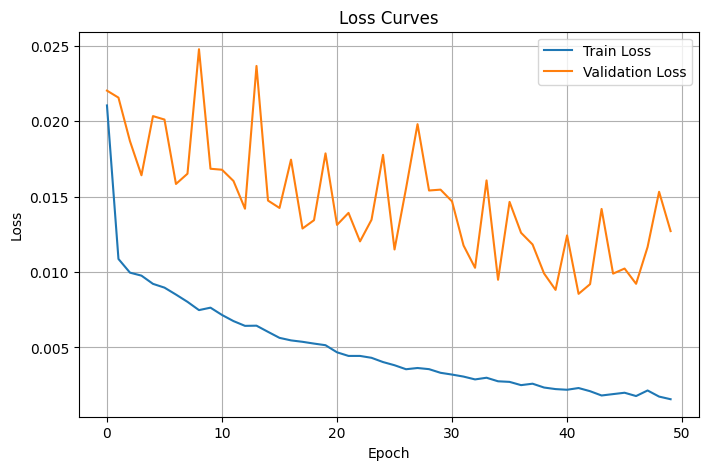

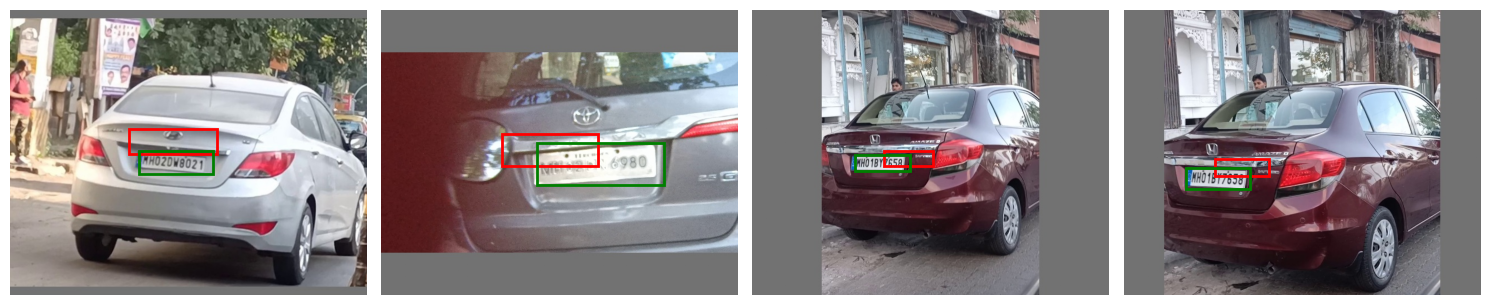

Mean IoU: 0.8538


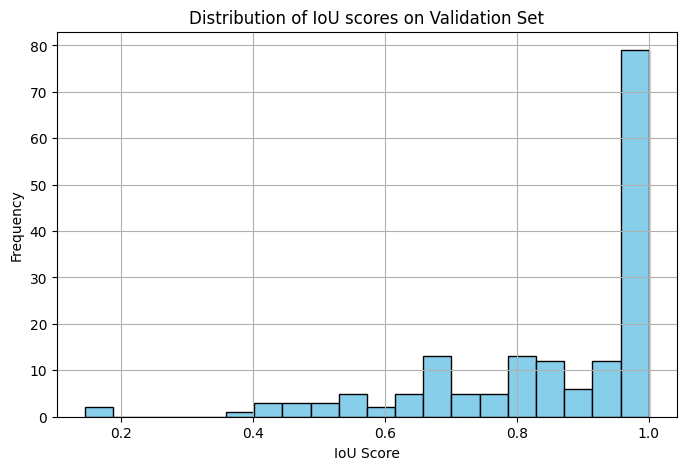

[tensor(0.8307),
 1,
 tensor(0.9303),
 1,
 1,
 tensor(0.9102),
 1,
 1,
 tensor(0.9806),
 1,
 tensor(0.9224),
 tensor(0.9551),
 1,
 tensor(0.7263),
 tensor(0.7779),
 tensor(0.9660),
 1,
 1,
 tensor(0.9382),
 tensor(0.6974),
 tensor(0.5519),
 tensor(0.3701),
 tensor(0.4961),
 tensor(0.6548),
 tensor(0.6789),
 tensor(0.8842),
 tensor(0.7378),
 1,
 tensor(0.9319),
 1,
 tensor(0.8040),
 tensor(0.6841),
 tensor(0.8482),
 tensor(0.9735),
 tensor(0.8691),
 tensor(0.6771),
 1,
 1,
 1,
 tensor(0.8121),
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 tensor(0.8584),
 tensor(0.9508),
 tensor(0.8002),
 tensor(0.7704),
 tensor(0.4290),
 1,
 tensor(0.6186),
 tensor(0.9834),
 tensor(0.9326),
 1,
 1,
 tensor(0.9228),
 tensor(0.9018),
 1,
 tensor(0.7681),
 tensor(0.9248),
 tensor(0.8328),
 tensor(0.8157),
 tensor(0.7910),
 tensor(0.7987),
 tensor(0.8618),
 tensor(0.8503),
 1,
 tensor(0.8546),
 tensor(0.9172),
 tensor(0.7947),
 tensor(0.6823),
 tensor(0.7763),
 1,
 1,
 tensor(0.7125),
 1,
 1,
 tensor(0.6704),
 tensor(0.729

In [36]:
#lets rerun the fourth model
#instantiate
fourth_model= FourthModel(dropout_rate= 0.0).to(device)

#optimizer
optimizer= torch.optim.AdamW(fourth_model.parameters(),
                             lr= 0.0001,
                             weight_decay= 0.0001)

#loss
criterion= nn.MSELoss()

#train
history_fourth= train_model(fourth_model,
                                 train_loader,
                                 val_loader,
                                 criterion,
                                 optimizer,
                                 device,
                                 epochs= 50,
                                 model_name= 'fourth_model.pth')

#plot loss curves
plot_loss_curves(history_fourth)

#load best saved model
fourth_model.load_state_dict(torch.load('fourth_model.pth'))
fourth_model.to(device)

#visualize predictions
show_predictions(fourth_model, val_loader, device, num_images= 4)

#tuned validation IoU
evaluate_iou_with_plot(fourth_model, val_loader, device)

Grid Search: 8 combinations

running: LR= 0.001, Dropout= 0.2, WD= 0.0001

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.8723


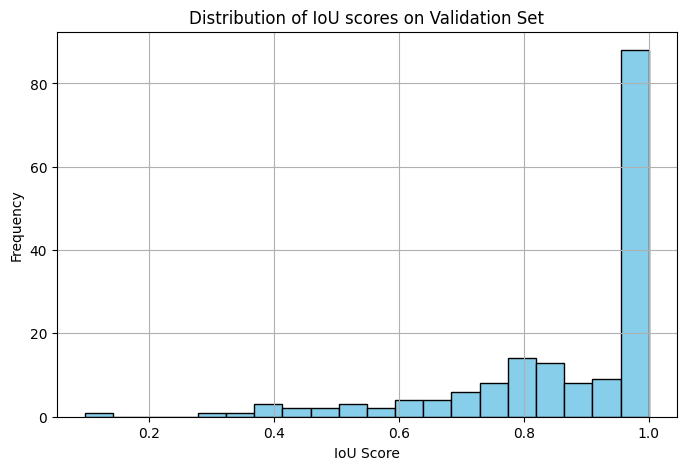

Finished: Val Loss= 0.0134, 
Mean IoU= 0.8723

running: LR= 0.001, Dropout= 0.2, WD= 0.001

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.8945


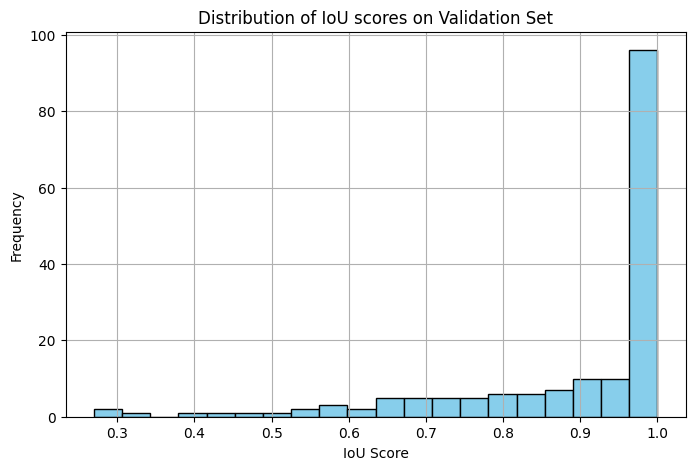

Finished: Val Loss= 0.0166, 
Mean IoU= 0.8945

running: LR= 0.001, Dropout= 0.3, WD= 0.0001

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.8682


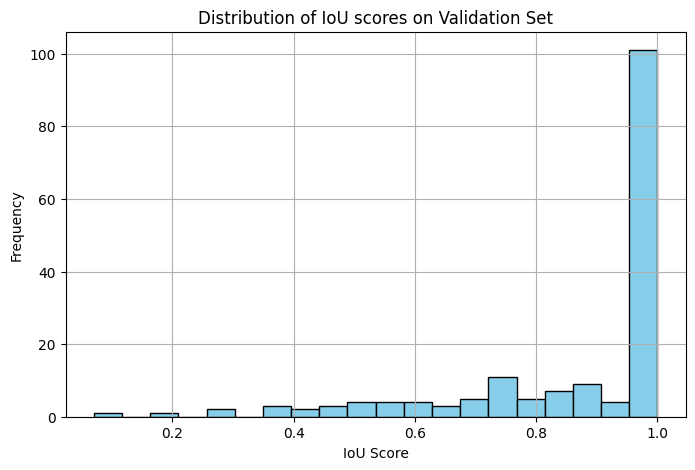

Finished: Val Loss= 0.0168, 
Mean IoU= 0.8682

running: LR= 0.001, Dropout= 0.3, WD= 0.001

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.8967


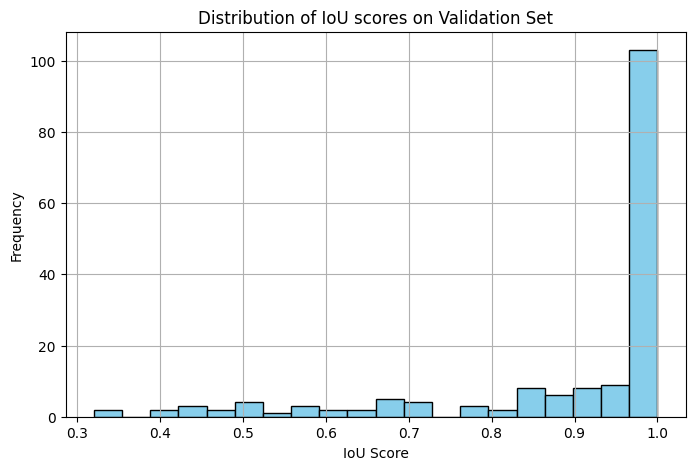

Finished: Val Loss= 0.0174, 
Mean IoU= 0.8967

running: LR= 0.0001, Dropout= 0.2, WD= 0.0001

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.8688


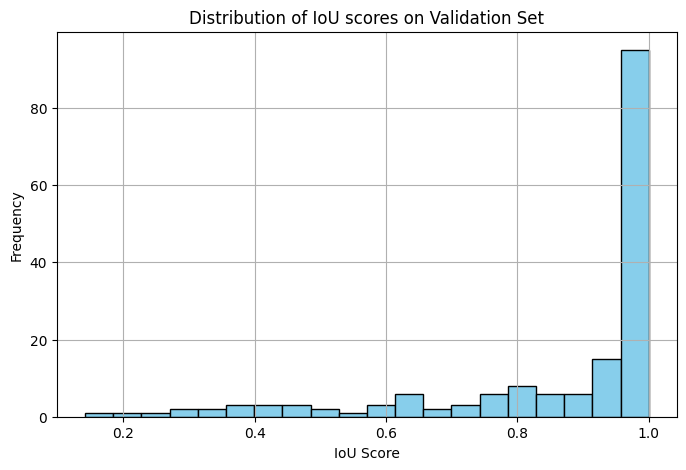

Finished: Val Loss= 0.0131, 
Mean IoU= 0.8688

running: LR= 0.0001, Dropout= 0.2, WD= 0.001

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.8653


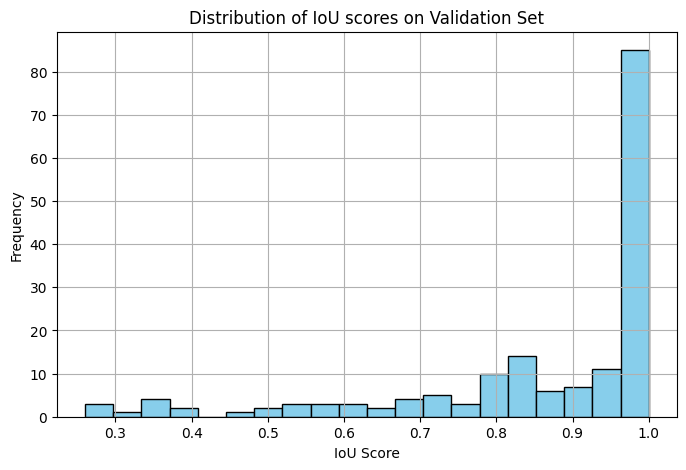

Finished: Val Loss= 0.0126, 
Mean IoU= 0.8653

running: LR= 0.0001, Dropout= 0.3, WD= 0.0001

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.8633


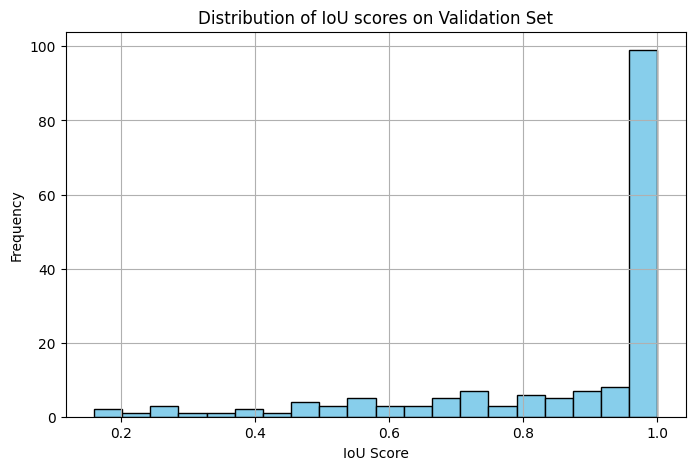

Finished: Val Loss= 0.0135, 
Mean IoU= 0.8633

running: LR= 0.0001, Dropout= 0.3, WD= 0.001

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.8832


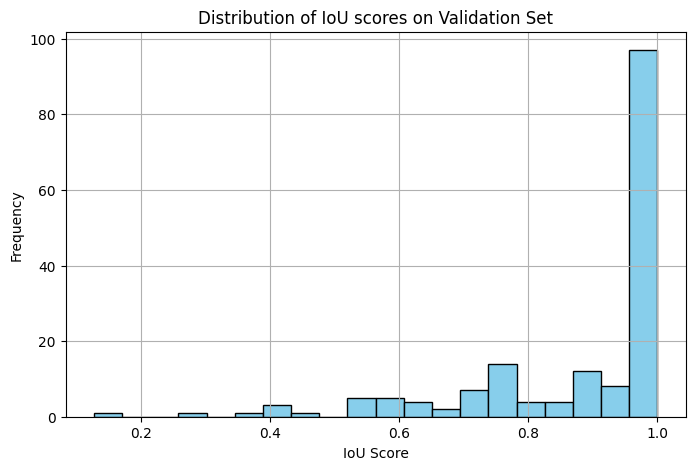

Finished: Val Loss= 0.0132, 
Mean IoU= 0.8832

best hyperparameter combinations:


learning_rate  dropout  weight_decay  val_loss  mean_iou
3         0.0010      0.3        0.0010  0.017402  0.896651
1         0.0010      0.2        0.0010  0.016625  0.894505
7         0.0001      0.3        0.0010  0.013236  0.883181
0         0.0010      0.2        0.0001  0.013411  0.872273
4         0.0001      0.2        0.0001  0.013054  0.868816
2         0.0010      0.3        0.0001  0.016830  0.868201
5         0.0001      0.2        0.0010  0.012558  0.865335
6         0.0001      0.3        0.0001  0.013492  0.863317

In [35]:
#define the grid search parameters
learning_rates= [1e-3, 1e-4] #[1e-3, 1e-4, 1e-5]
dropout_rates= [0.2, 0.3] #[0.2, 0.3, 0.4]
weight_decays= [1e-4, 1e-3] #[1e-4, 1e-3, 0]

#list to store search results
results= []

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
#loss
criterion= nn.MSELoss()

#grid search
search_combinations= list(itertools.product(learning_rates,
                                            dropout_rates,
                                            weight_decays))
print(f"Grid Search: {len(search_combinations)} combinations\n")

for lr, dropout, wd in search_combinations:
  print(f"running: LR= {lr}, Dropout= {dropout}, WD= {wd}")

  #define model
  model= FourthModel(dropout_rate= dropout).to(device)

  #define optimizer
  optimizer= torch.optim.AdamW(model.parameters(),
                               lr=lr,
                               weight_decay= wd)

  #train
  history= train_model(model,
                       train_loader,
                       val_loader,
                       criterion,
                       optimizer,
                       device,
                       epochs= 15,
                       model_name= 'fourth_model.pth',
                       verbose= False)

  #load best model
  model.load_state_dict(torch.load('fourth_model.pth'))
  model.eval()

  #IoU score
  mean_ious= evaluate_iou_with_plot(model, val_loader, device)
  mean_iou= np.mean(mean_ious)

  #save results
  results.append({"learning_rate": lr,
                  "dropout": dropout,
                  "weight_decay": wd,
                  "val_loss": min(history['val_loss']),
                  "mean_iou": mean_iou})

  print(f"Finished: Val Loss= {min(history['val_loss']):.4f}, ")
  print(f"Mean IoU= {mean_iou:.4f}\n")

#make a results table
results_df= pd.DataFrame(results)
results_df= results_df.sort_values(by= ['mean_iou'], ascending= False)

print("best hyperparameter combinations:")
display(results_df)

Grid Search: 12 combinations

running: LR= 0.01, Dropout= 0, WD= 0.001

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.8920


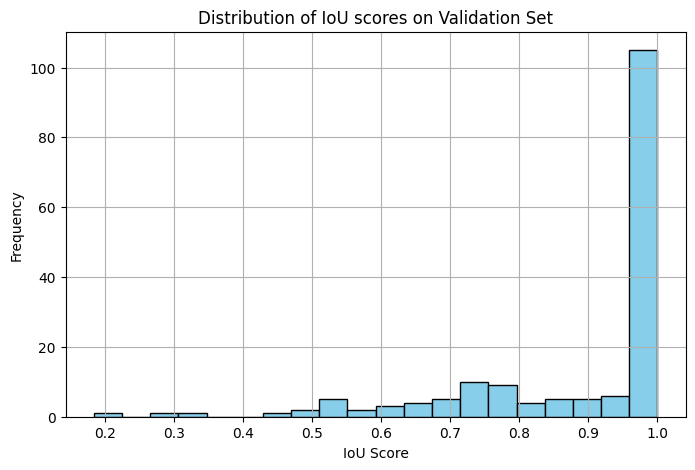

Finished: Val Loss= 0.0165, 
Mean IoU= 0.8920

running: LR= 0.01, Dropout= 0, WD= 1e-05

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.8795


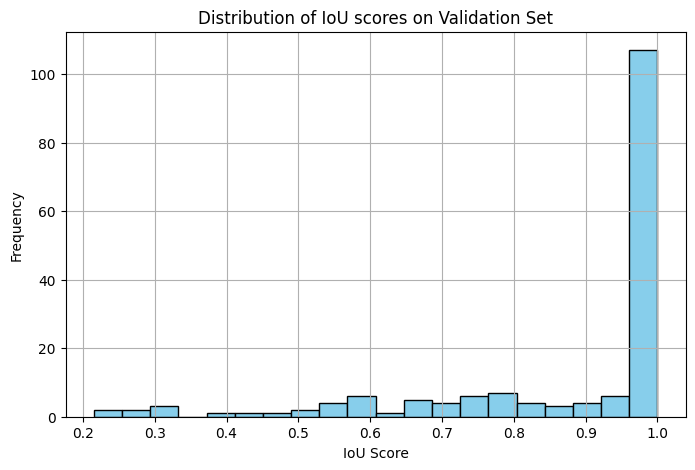

Finished: Val Loss= 0.0176, 
Mean IoU= 0.8795

running: LR= 0.01, Dropout= 0.1, WD= 0.001

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.8879


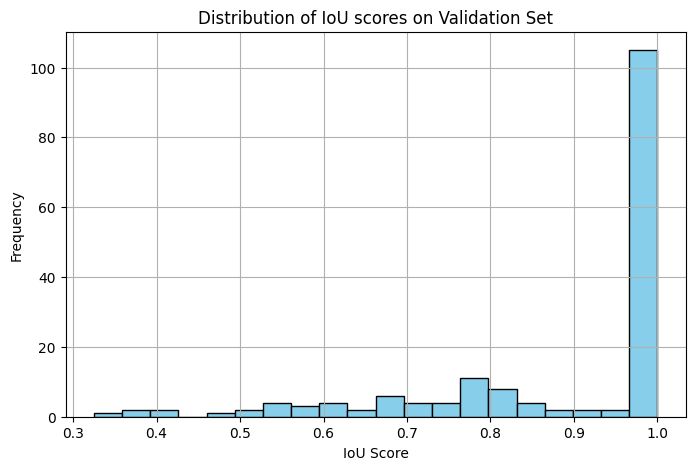

Finished: Val Loss= 0.0190, 
Mean IoU= 0.8879

running: LR= 0.01, Dropout= 0.1, WD= 1e-05

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.8983


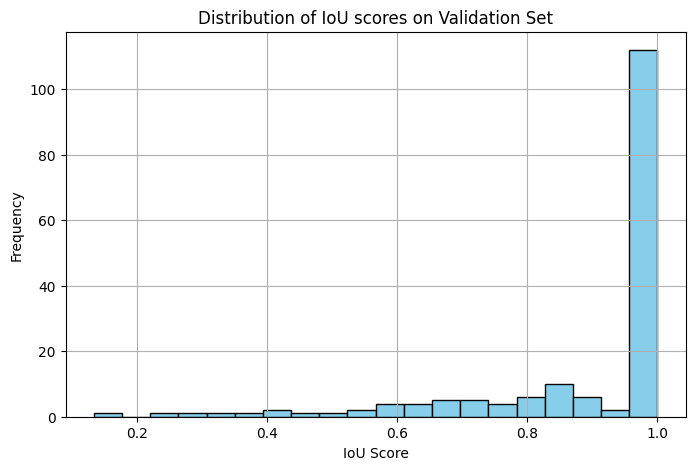

Finished: Val Loss= 0.0202, 
Mean IoU= 0.8983

running: LR= 0.01, Dropout= 0.3, WD= 0.001

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.9006


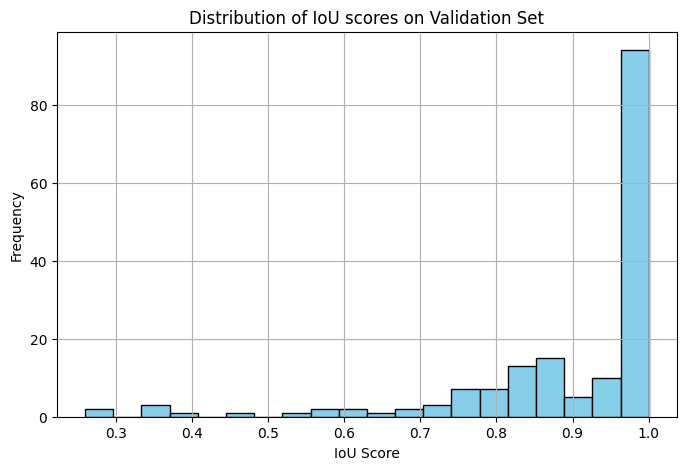

Finished: Val Loss= 0.0191, 
Mean IoU= 0.9006

running: LR= 0.01, Dropout= 0.3, WD= 1e-05

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.8930


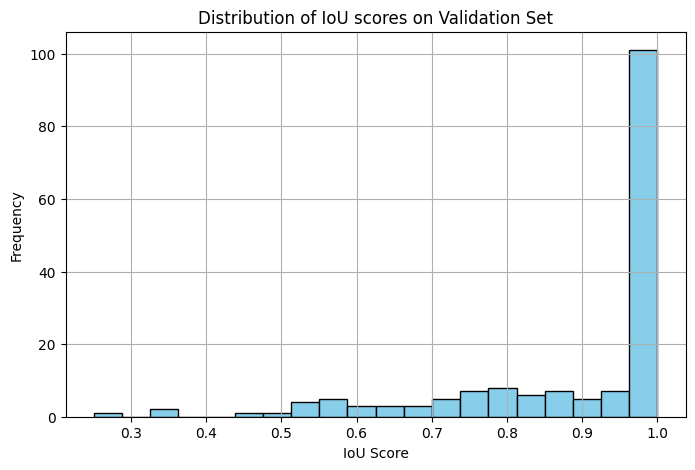

Finished: Val Loss= 0.0180, 
Mean IoU= 0.8930

running: LR= 0.001, Dropout= 0, WD= 0.001

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.8437


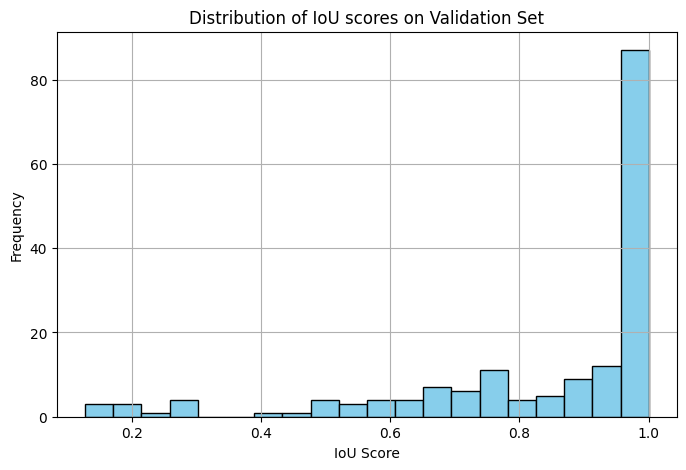

Finished: Val Loss= 0.0140, 
Mean IoU= 0.8437

running: LR= 0.001, Dropout= 0, WD= 1e-05

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.8587


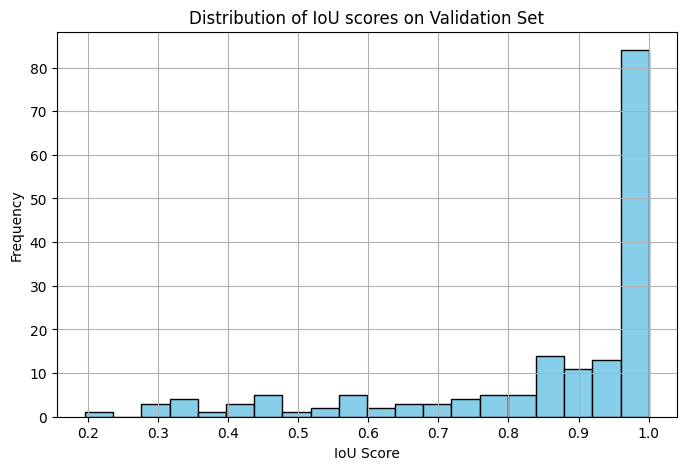

Finished: Val Loss= 0.0164, 
Mean IoU= 0.8587

running: LR= 0.001, Dropout= 0.1, WD= 0.001

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.9150


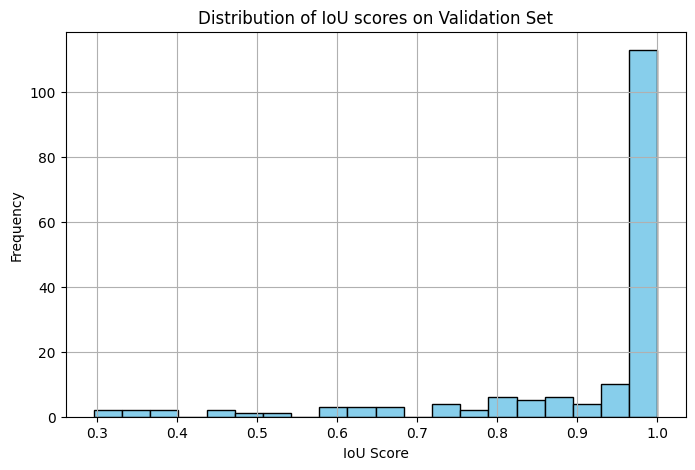

Finished: Val Loss= 0.0156, 
Mean IoU= 0.9150

running: LR= 0.001, Dropout= 0.1, WD= 1e-05

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.8965


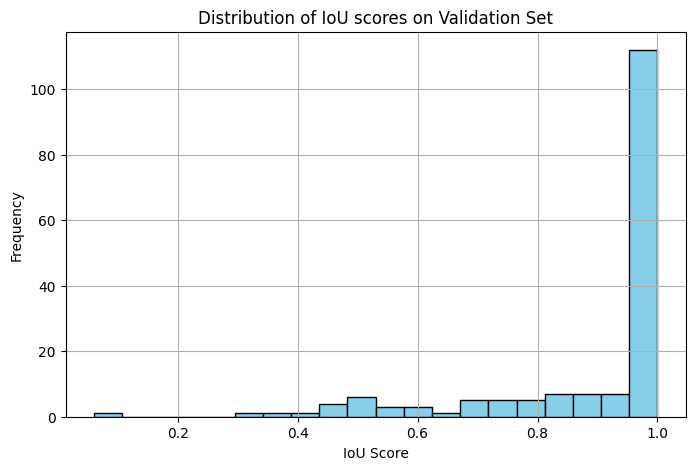

Finished: Val Loss= 0.0168, 
Mean IoU= 0.8965

running: LR= 0.001, Dropout= 0.3, WD= 0.001

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.8852


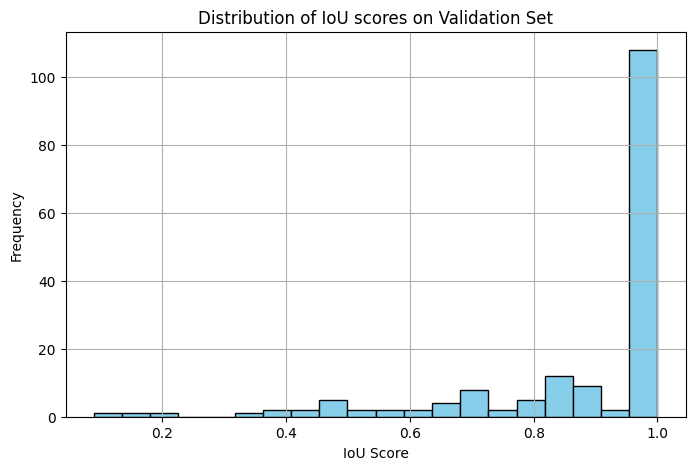

Finished: Val Loss= 0.0166, 
Mean IoU= 0.8852

running: LR= 0.001, Dropout= 0.3, WD= 1e-05

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15
Mean IoU: 0.8684


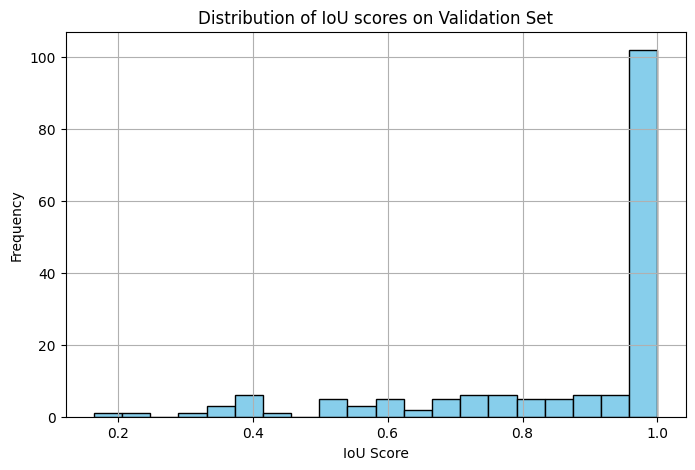

Finished: Val Loss= 0.0162, 
Mean IoU= 0.8684

best hyperparameter combinations:


learning_rate  dropout  weight_decay  val_loss  mean_iou
8           0.001      0.1       0.00100  0.015640  0.915015
4           0.010      0.3       0.00100  0.019089  0.900611
3           0.010      0.1       0.00001  0.020150  0.898263
9           0.001      0.1       0.00001  0.016806  0.896458
5           0.010      0.3       0.00001  0.017976  0.892976
0           0.010      0.0       0.00100  0.016472  0.892007
2           0.010      0.1       0.00100  0.019024  0.887920
10          0.001      0.3       0.00100  0.016583  0.885229
1           0.010      0.0       0.00001  0.017607  0.879505
11          0.001      0.3       0.00001  0.016210  0.868396
7           0.001      0.0       0.00001  0.016436  0.858709
6           0.001      0.0       0.00100  0.014037  0.843661

In [38]:
#define the grid search parameters
learning_rates= [1e-2, 1e-3] #[1e-3, 1e-4, 1e-5]
dropout_rates= [0, 0.1, 0.3] #[0.2, 0.3, 0.4]
weight_decays= [1e-3, 1e-5] #[1e-4, 1e-3, 0]

#list to store search results
results= []

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
#loss
criterion= nn.MSELoss()

#grid search
search_combinations= list(itertools.product(learning_rates,
                                            dropout_rates,
                                            weight_decays))
print(f"Grid Search: {len(search_combinations)} combinations\n")

for lr, dropout, wd in search_combinations:
  print(f"running: LR= {lr}, Dropout= {dropout}, WD= {wd}")

  #define model
  model= FourthModel(dropout_rate= dropout).to(device)

  #define optimizer
  optimizer= torch.optim.AdamW(model.parameters(),
                               lr=lr,
                               weight_decay= wd)

  #train
  history= train_model(model,
                       train_loader,
                       val_loader,
                       criterion,
                       optimizer,
                       device,
                       epochs= 15,
                       model_name= 'fourth_model.pth',
                       verbose= False)

  #load best model
  model.load_state_dict(torch.load('fourth_model.pth'))
  model.eval()

  #IoU score
  mean_ious= evaluate_iou_with_plot(model, val_loader, device)
  mean_iou= np.mean(mean_ious)

  #save results
  results.append({"learning_rate": lr,
                  "dropout": dropout,
                  "weight_decay": wd,
                  "val_loss": min(history['val_loss']),
                  "mean_iou": mean_iou})

  print(f"Finished: Val Loss= {min(history['val_loss']):.4f}, ")
  print(f"Mean IoU= {mean_iou:.4f}\n")

#make a results table
results_df= pd.DataFrame(results)
results_df= results_df.sort_values(by= ['mean_iou'], ascending= False)

print("best hyperparameter combinations:")
display(results_df)


Epoch 1/50
Train Loss: 0.0162 | Val Loss: 0.0207
Saved new best model: fourth_model.pth

Epoch 2/50
Train Loss: 0.0122 | Val Loss: 0.0199
Saved new best model: fourth_model.pth

Epoch 3/50
Train Loss: 0.0118 | Val Loss: 0.0206

Epoch 4/50
Train Loss: 0.0114 | Val Loss: 0.0226

Epoch 5/50
Train Loss: 0.0110 | Val Loss: 0.0169
Saved new best model: fourth_model.pth

Epoch 6/50
Train Loss: 0.0111 | Val Loss: 0.0193

Epoch 7/50
Train Loss: 0.0107 | Val Loss: 0.0184

Epoch 8/50
Train Loss: 0.0103 | Val Loss: 0.0166
Saved new best model: fourth_model.pth

Epoch 9/50
Train Loss: 0.0098 | Val Loss: 0.0717

Epoch 10/50
Train Loss: 0.0098 | Val Loss: 0.0243

Epoch 11/50
Train Loss: 0.0093 | Val Loss: 0.0211

Epoch 12/50
Train Loss: 0.0089 | Val Loss: 0.0163
Saved new best model: fourth_model.pth

Epoch 13/50
Train Loss: 0.0090 | Val Loss: 0.0187

Epoch 14/50
Train Loss: 0.0087 | Val Loss: 0.0190

Epoch 15/50
Train Loss: 0.0084 | Val Loss: 0.0149
Saved new best model: fourth_model.pth

Epoch 16/

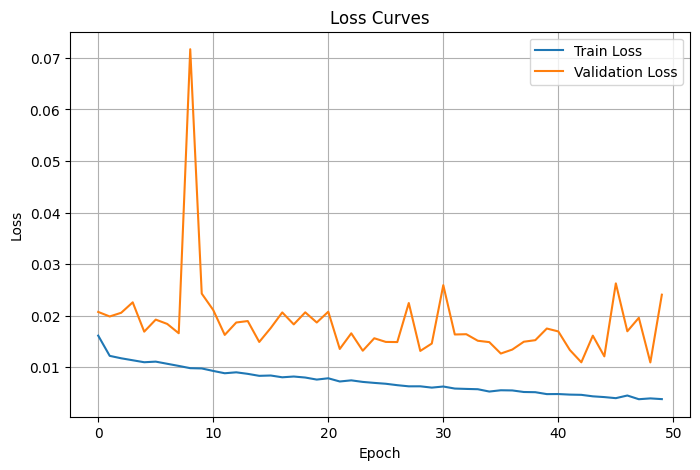

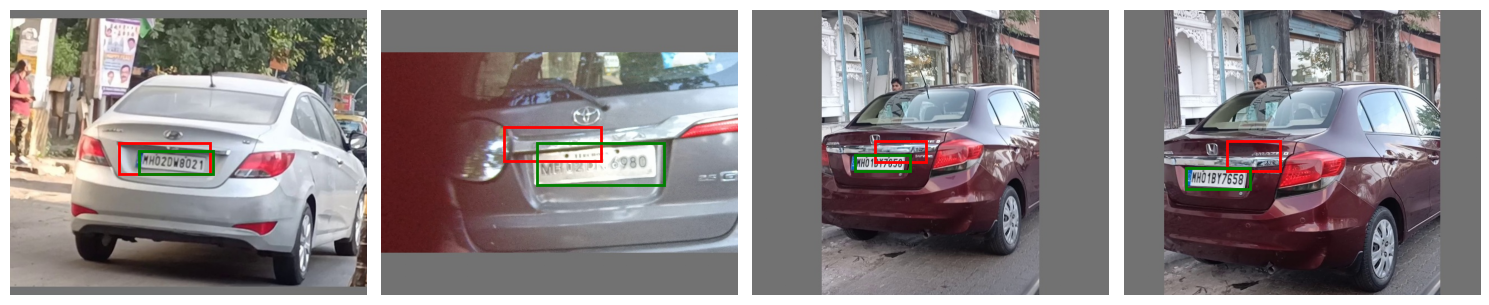

Mean IoU: 0.8069


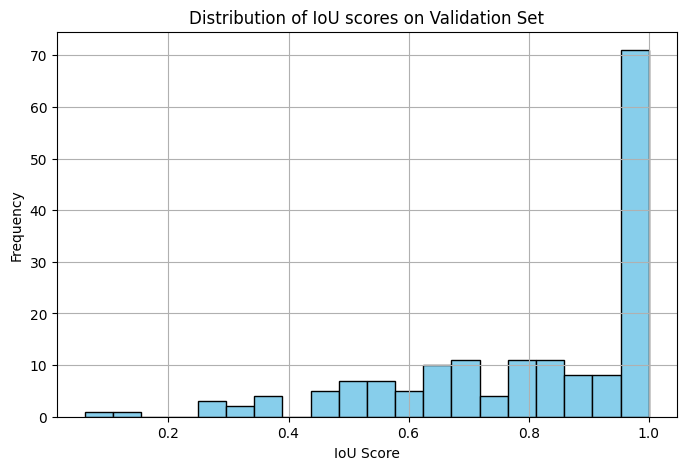

[tensor(0.5999),
 1,
 tensor(0.7347),
 tensor(0.6117),
 tensor(0.8748),
 tensor(0.7758),
 tensor(0.8480),
 tensor(0.8201),
 tensor(0.7890),
 tensor(0.8861),
 tensor(0.8370),
 tensor(0.8121),
 tensor(0.8282),
 tensor(0.9783),
 tensor(0.7535),
 1,
 tensor(0.8618),
 1,
 1,
 1,
 tensor(0.6223),
 tensor(0.3397),
 tensor(0.5438),
 tensor(0.6986),
 tensor(0.6245),
 tensor(0.3861),
 tensor(0.3704),
 tensor(0.4440),
 tensor(0.6541),
 tensor(0.8852),
 tensor(0.7801),
 tensor(0.7782),
 tensor(0.7952),
 tensor(0.9070),
 tensor(0.8435),
 tensor(0.6446),
 1,
 1,
 1,
 tensor(0.8404),
 tensor(0.9902),
 tensor(0.6170),
 1,
 tensor(0.8200),
 1,
 1,
 1,
 1,
 tensor(0.6901),
 1,
 1,
 tensor(0.4648),
 tensor(0.5630),
 tensor(0.5132),
 tensor(0.6464),
 tensor(0.6638),
 1,
 tensor(0.7622),
 1,
 tensor(0.9297),
 1,
 tensor(0.7806),
 tensor(0.7702),
 tensor(0.4491),
 tensor(0.5395),
 tensor(0.5452),
 tensor(0.7090),
 tensor(0.5243),
 tensor(0.5633),
 1,
 tensor(0.9763),
 tensor(0.6654),
 tensor(0.6703),
 tenso

In [39]:
# run the model with the best parameters

#instantiate
fourth_model= FourthModel(dropout_rate= 0.1).to(device)

#optimizer
optimizer= torch.optim.AdamW(fourth_model.parameters(),
                             lr= 0.001,
                             weight_decay= 0.001)

#loss
criterion= nn.MSELoss()

#train
history_fourth= train_model(fourth_model,
                                 train_loader,
                                 val_loader,
                                 criterion,
                                 optimizer,
                                 device,
                                 epochs= 50,
                                 model_name= 'fourth_model.pth')

#plot loss curves
plot_loss_curves(history_fourth)

#load best saved model
fourth_model.load_state_dict(torch.load('fourth_model.pth'))
fourth_model.to(device)

#visualize predictions
show_predictions(fourth_model, val_loader, device, num_images= 4)

#tuned validation IoU
evaluate_iou_with_plot(fourth_model, val_loader, device)


Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15


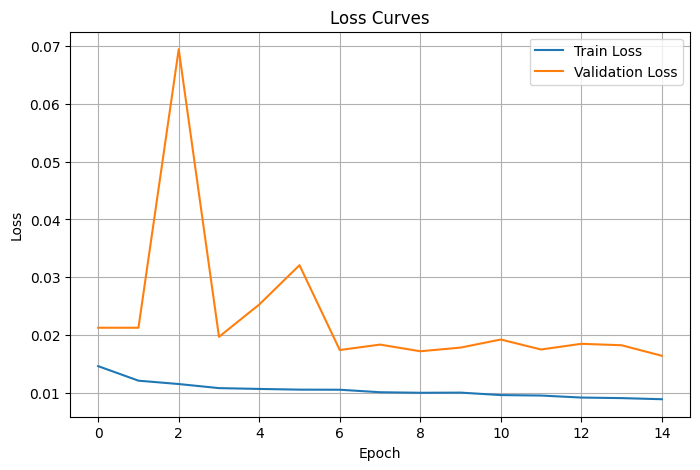

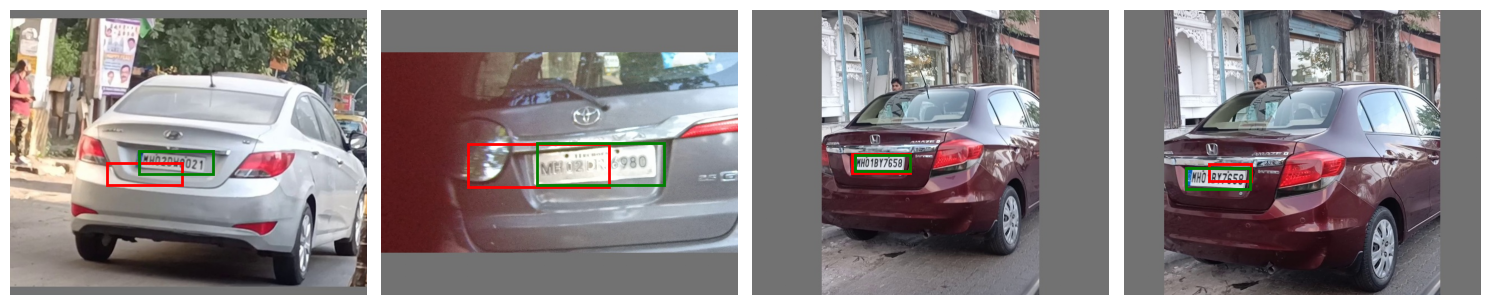

Mean IoU: 0.8771


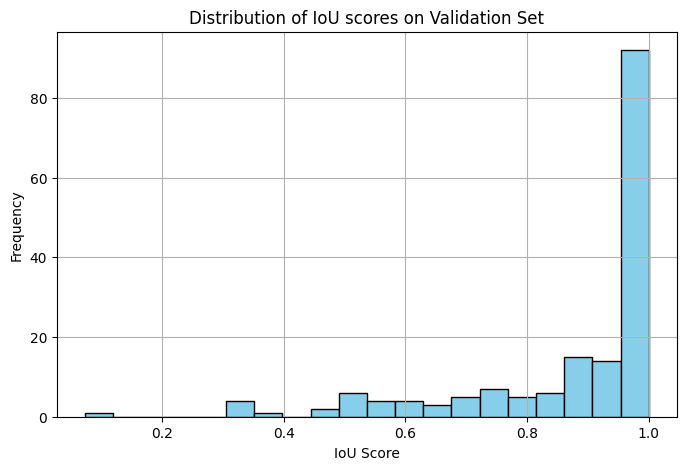

[tensor(0.9850),
 tensor(0.9360),
 tensor(0.9863),
 tensor(0.7546),
 tensor(0.9705),
 tensor(0.9268),
 tensor(0.9444),
 tensor(0.8991),
 tensor(0.8904),
 tensor(0.9008),
 tensor(0.8829),
 tensor(0.8569),
 tensor(0.8670),
 1,
 1,
 1,
 tensor(0.8774),
 1,
 tensor(0.9997),
 tensor(0.9130),
 tensor(0.4918),
 tensor(0.5230),
 tensor(0.7322),
 tensor(0.4592),
 tensor(0.9992),
 tensor(0.7301),
 tensor(0.6769),
 tensor(0.8991),
 tensor(0.9255),
 1,
 1,
 tensor(0.6178),
 tensor(0.8451),
 tensor(0.8276),
 tensor(0.9322),
 1,
 1,
 1,
 1,
 1,
 tensor(0.8948),
 1,
 1,
 1,
 tensor(0.9924),
 1,
 1,
 tensor(0.9724),
 1,
 tensor(0.9907),
 tensor(0.5608),
 tensor(0.5325),
 tensor(0.9347),
 tensor(0.7308),
 tensor(0.8804),
 1,
 tensor(0.9152),
 tensor(0.7909),
 tensor(0.8617),
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 tensor(0.9344),
 tensor(0.6826),
 tensor(0.5782),
 tensor(0.8129),
 1,
 1,
 1,
 tensor(0.9057),
 1,
 1,
 1,
 tensor(0.5951),
 tensor(0.6815),
 1,
 1,


In [41]:
# run the model with the best parameters

#instantiate
fourth_model= FourthModel(dropout_rate= 0.1).to(device)

#optimizer
optimizer= torch.optim.AdamW(fourth_model.parameters(),
                             lr= 0.001,
                             weight_decay= 0.001)

#loss
criterion= nn.MSELoss()

#train
history_fourth= train_model(fourth_model,
                                 train_loader,
                                 val_loader,
                                 criterion,
                                 optimizer,
                                 device,
                                 epochs= 15,
                                 model_name= 'fourth_model.pth',
                                 verbose= False)

#plot loss curves
plot_loss_curves(history_fourth)

#load best saved model
fourth_model.load_state_dict(torch.load('fourth_model.pth'))
fourth_model.to(device)

#visualize predictions
show_predictions(fourth_model, val_loader, device, num_images= 4)

#tuned validation IoU
evaluate_iou_with_plot(fourth_model, val_loader, device)